# Credit Card Fraud Detection & Model Interpretability

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QFgAuYFmcEfG-Hy3vAQGFoHepHkPJgm0?usp=sharing)

---

## Overview

In this notebook we perform the following steps:
1. **Exploratory Data Analysis (EDA):** Examine class distribution, correlations, and feature distributions.
2. **Preprocessing & Model Training:** Standardize selected features, split data, and train a Random Forest classifier.
3. **Model Evaluation & Feature Importances:** Evaluate the model and visualize the top features.
4. **Model Interpretation:** Generate Partial Dependence Plots (PDP) with ICE curves and Accumulated Local Effects (ALE) plots.

[Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

---

## Why We Chose These Methods

- **Random Forest Classifier:**  
  Chosen for its robustness, ability to handle high-dimensional data, and its built-in mechanism for dealing with imbalanced datasets (using `class_weight="balanced"`).

- **PDP with ICE Curves:**  
  Partial Dependence Plots (PDPs) provide a clear view of the average effect of a feature on model predictions. ICE curves supplement this by showing the variability in predictions across individual instances.  
  *However, note that PDPs may be misleading when features are correlated.*

- **Accumulated Local Effects (ALE) Plots:**  
  ALE plots overcome some of PDPs’ limitations by computing the local effect of a feature on predictions, making them more reliable in the presence of correlated features.

---

## Strengths of Our Approach

- **Random Forests:**  
  - Robust to overfitting.
  - Naturally handle nonlinear relationships.
  - Easily interpretable through feature importance.

- **PDP/ICE Visualizations:**  
  - Show both global (PDP) and local (ICE) feature effects.
  - Easy to understand when features are nearly independent.

- **ALE Plots:**  
  - Unbiased in the presence of feature correlations.
  - Provide a more realistic view of feature influence compared to PDPs in many real-world datasets.

---

## Potential Improvements

- **Hyperparameter Tuning:**  
  Optimize the Random Forest’s hyperparameters (e.g., tree depth, number of features per split) for potentially better performance.

- **Additional Interpretability Tools:**  
  Incorporate alternative model explanation techniques such as SHAP or LIME for further insight.

- **Handling Imbalance:**  
  Experiment with resampling techniques (e.g., SMOTE) to further address class imbalance.

- **Extended EDA:**  
  Deepen the exploratory analysis (e.g., using additional visualization or statistical tests) to better understand the data.

---

## Citations

1. Molnar, C. (2020). *Interpretable Machine Learning*. Retrieved from [https://christophm.github.io/interpretable-ml-book/](https://christophm.github.io/interpretable-ml-book/)
2. Apley, D. W., & Zhu, J. (2020). Visualizing the effects of predictor variables in black box supervised learning models. *Journal of the Royal Statistical Society: Series B*, 82(4), 1059–1086.
3. Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.

---

## Notebook Code


Class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


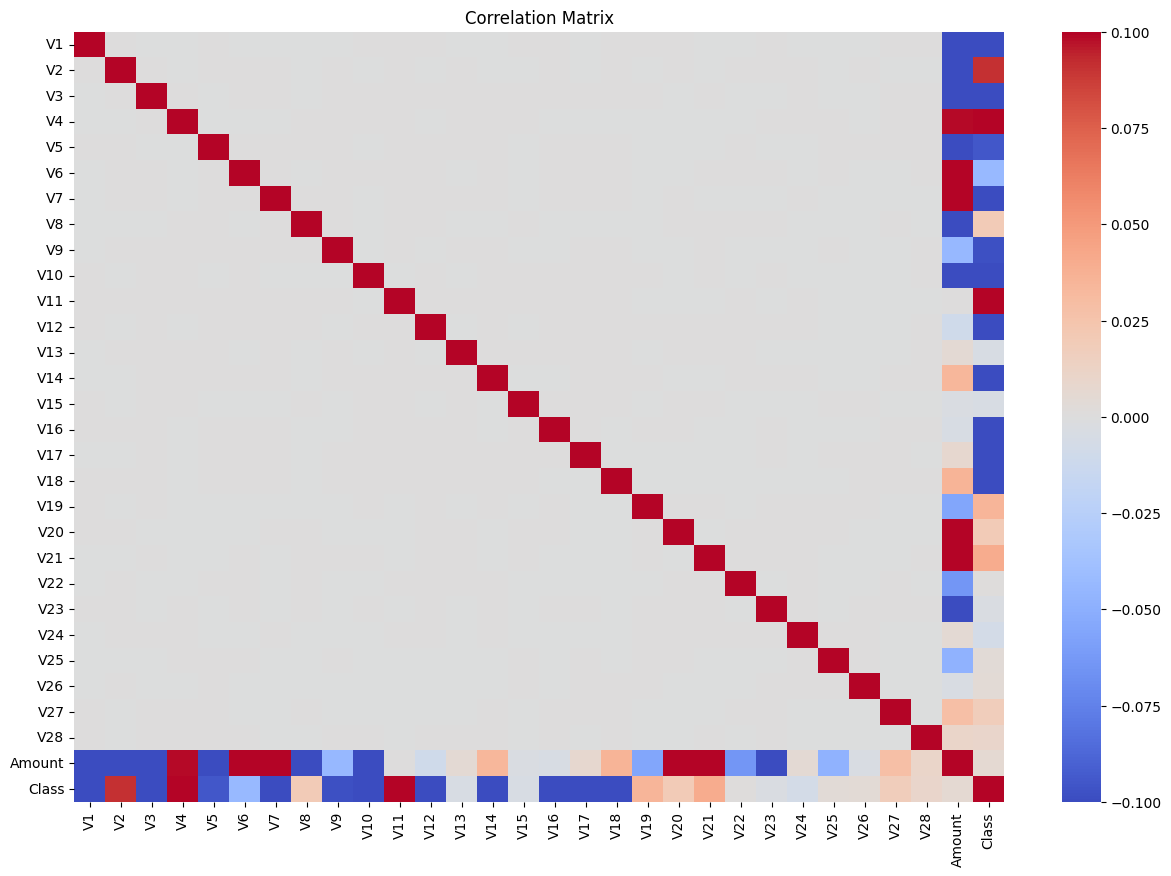

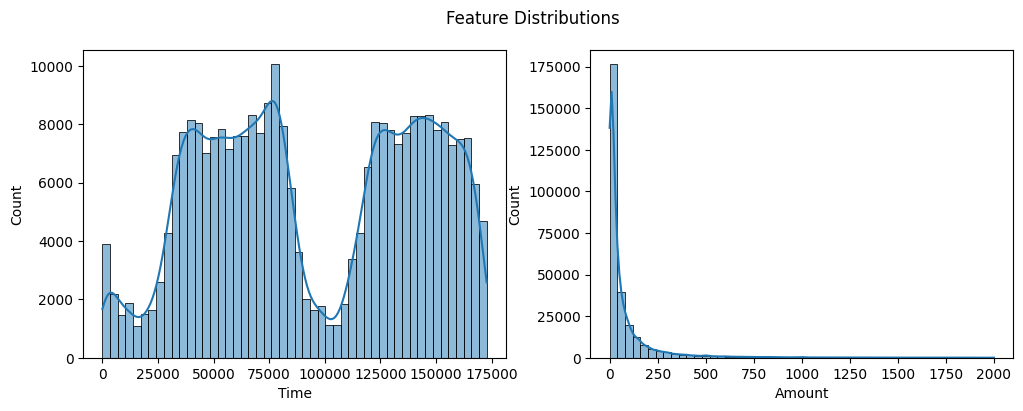

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.71      0.82       148

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC: 0.9275


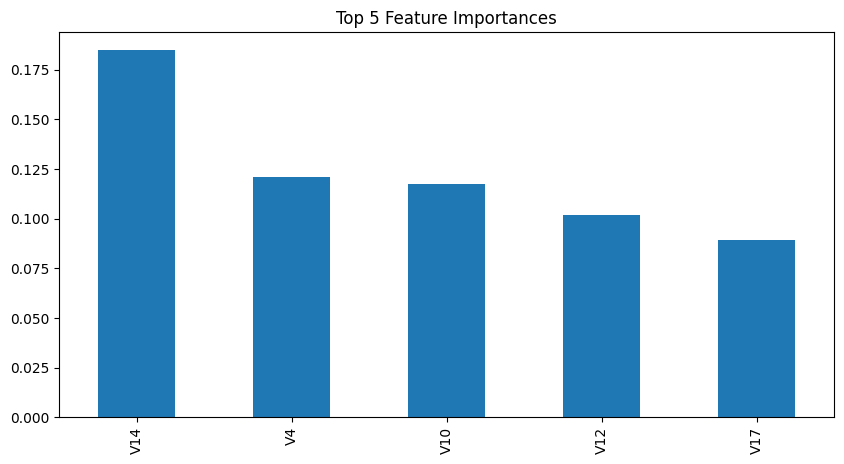

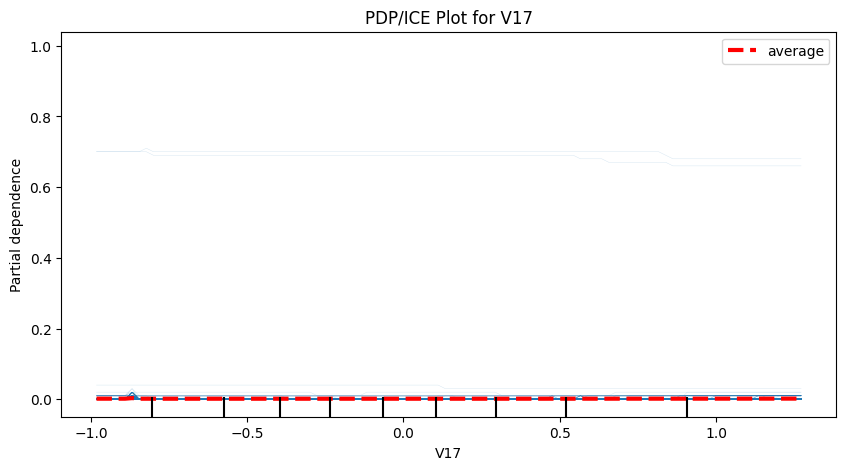

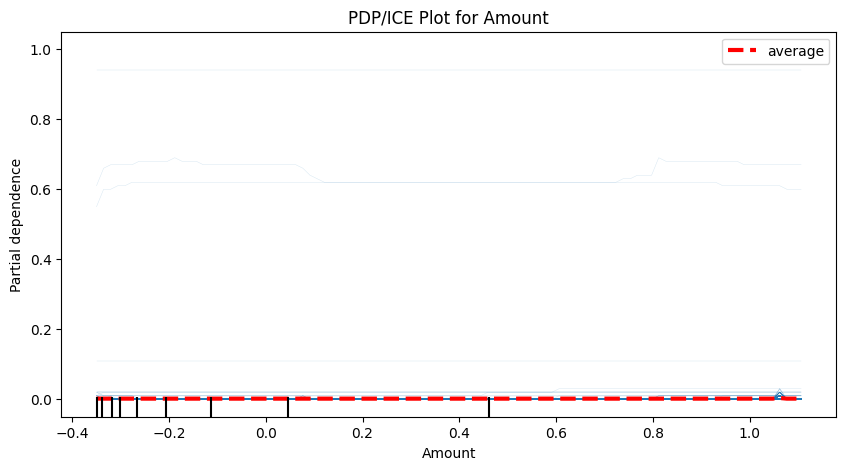

PyALE._ALE_generic:INFO: Continuous feature detected.


<Figure size 1000x500 with 0 Axes>

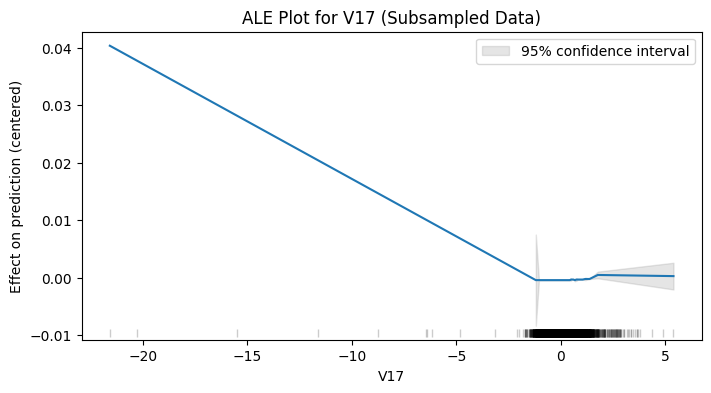

PyALE._ALE_generic:INFO: Continuous feature detected.


<Figure size 1000x500 with 0 Axes>

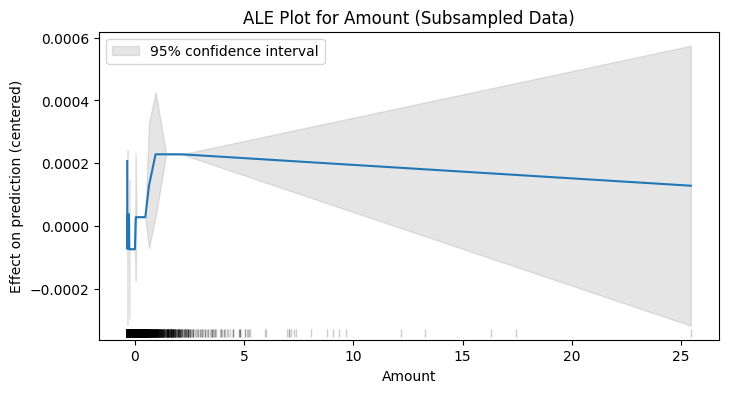

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn PyALE scikit-learn-intelex -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
from sklearn.preprocessing import StandardScaler

from google.colab import drive, files

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

drive.mount("/content/drive")
file_path = "/content/drive/MyDrive/creditcard.csv"
df = pd.read_csv(file_path)
print("Class distribution:\n", df["Class"].value_counts(normalize=True))

corr_matrix = df.drop("Time", axis=1).corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, vmin=-0.1, vmax=0.1, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df["Time"], ax=ax[0], bins=50, kde=True)
sns.histplot(df[df["Amount"] < 2000]["Amount"], ax=ax[1], bins=50, kde=True)
plt.suptitle("Feature Distributions")
plt.show()

scaler = StandardScaler()
df[["Time", "Amount"]] = scaler.fit_transform(df[["Time", "Amount"]])

X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

model = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(classification_report(y_test, preds))
print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.4f}")

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(10,5))
importances.plot(kind="bar")
plt.title("Top 5 Feature Importances")
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=["V17"],
    kind="both", 
    ice_lines_kw={"color":"tab:blue", "alpha":0.2, "linewidth":0.3},
    pd_line_kw={"color":"red", "linewidth":3},
    ax=ax
)
ax.set_title("PDP/ICE Plot for V17")
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=["Amount"],
    kind="both",
    ice_lines_kw={"color":"tab:blue", "alpha":0.2, "linewidth":0.3},
    pd_line_kw={"color":"red", "linewidth":3},
    ax=ax
)
ax.set_title("PDP/ICE Plot for Amount")
plt.show()

X_train_sample = X_train.sample(n=5000, random_state=42)

wrapper = ModelWrapper(model)

plt.figure(figsize=(10,5))
ale(
    X=X_train_sample,
    model=wrapper,
    feature=["V17"],
    grid_size=50
)
plt.title("ALE Plot for V17 (Subsampled Data)")
plt.show()

plt.figure(figsize=(10,5))
ale(
    X=X_train_sample,
    model=wrapper,
    feature=["Amount"],
    grid_size=50
)
plt.title("ALE Plot for Amount (Subsampled Data)")
plt.show()

## Key Observations

### 1. Correlation Matrix
- Most features exhibit low correlations (near 0) with each other, indicating minimal multicollinearity.
- Some features show mild correlations with `Class`, which could be predictive indicators.

### 2. Feature Distributions
- **Time:** Displays a bi-modal distribution, indicating patterns in transaction timing.
- **Amount:** Highly skewed distribution with most values concentrated below 500. Limiting the range for visualization was a smart choice to reduce the influence of outliers.

### 3. Feature Importances
- The top features (`V14`, `V4`, `V10`, `V12`, `V17`) contribute significantly to model predictions.
- `V14` stands out as the most critical predictor, which may indicate it captures a key fraud-related characteristic.

### 4. Partial Dependence Plots (PDP) and ICE Curves
- **V17 and Amount:** Show minimal impact on predictions across the range of values. This suggests that while these features are important, their individual effect on the predicted probability is not strong or linear.

### 5. Accumulated Local Effects (ALE) Plots
- **V17:** Displays a downward trend, indicating a negative effect on the prediction probability as values increase.
- **Amount:** The effect on prediction is small but significant at lower transaction amounts, which aligns with the intuition that lower amounts are less likely to be fraudulent.

---

## Model Performance
### Classification Report
- Precision, recall, and F1-score for class `1` (fraudulent transactions) are reasonably high, but recall (0.70) could be improved. This indicates that some fraudulent transactions are being missed.
- **ROC-AUC of 0.9275** shows the model has a strong ability to distinguish between classes.

---

## Recommendations
1. **Improve Recall:** Consider resampling techniques such as SMOTE or hyperparameter tuning to boost recall for class `1`.
2. **Explore SHAP Values:** To gain more granular insights into individual predictions.
3. **Extend ALE Plots:** Add additional features for ALE analysis to confirm feature correlations.

---

